In [60]:
from math import *
import numpy as np 
import pandas as pd

In [110]:
possible_distance_metrics = ["euclidean", "manhattan", "cosine"]
max_k = 40
# csv_dataset = "../../data/interim/1/knn/spotify_un"
train_data_path = "../../data/interim/1/knn/train_1.csv"
test_data_path = "../../data/interim/1/knn/test_1.csv"
val_data_path = "../../data/interim/1/knn/validation_1.csv"
unique_dataset_path = "../../data/interim/1/knn/spotify_unique.csv"

In [111]:

# Load the data from the CSV file
data = pd.read_csv(unique_dataset_path)

# Remove the first unnamed column
data = data.drop(data.columns[0], axis=1)

# Convert 'explicit' (bool) to int
data['explicit'] = data['explicit'].astype(int)

numeric_features = ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
categorical_features = ['track_id', 'artists', 'album_name', 'track_name']
features_to_drop = ['time_signature', 'duration_ms']

# Normalize numeric features using min-max normalization
data[numeric_features] = (data[numeric_features] - data[numeric_features].min()) / (data[numeric_features].max() - data[numeric_features].min())

# Create dictionaries for storing encodings and inverse encodings
encodings = {}
inverse_encodings = {}

# Encode categorical features and store the mappings
for feature in categorical_features:
    # Create a mapping for the feature
    unique_values = data[feature].unique()
    encoding_map = {value: idx for idx, value in enumerate(unique_values)}
    inverse_encoding_map = {idx: value for value, idx in encoding_map.items()}
    
    # Replace the feature with its encoded values
    data[feature] = data[feature].map(encoding_map)
    
    # Store the mappings
    encodings[feature] = encoding_map
    inverse_encodings[feature] = inverse_encoding_map


# Encode 'track_genre'
track_genre_mapping = {genre: idx for idx, genre in enumerate(data['track_genre'].unique())}
data['track_genre'] = data['track_genre'].map(track_genre_mapping)

# remove all the categorical features for now
data = data.drop(columns=categorical_features)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)
# # Split the data into features (X) and target (y)
# X_pts = data.iloc[:, :-1].values  # Assuming all columns except last are features
# Y_pts = data.iloc[:, -1].values  # Assuming last column is the target

train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))

train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

# Write the training data to the specified path
train_data.to_csv(train_data_path, index=False)

# Write the validation data to the specified path
val_data.to_csv(val_data_path, index=False)

# Write the test data to the specified path
test_data.to_csv(test_data_path, index=False)


In [161]:
# distance metrics only defined for int/float and not on categorical values 
# can use binary indicator for categorical values 

# def euclidean_distance(row1, row2):
#     dist = 0.0
#     for i in range(len(row1)):
#         if isinstance(row1[i], (int, float)) and isinstance(row2[i], (int, float)):
#             dist += (row1[i] - row2[i]) ** 2
#     dist = sqrt(dist)
#     return dist

# def manhattan_distance(row1, row2):
#     dist = 0.0
#     for i in range(len(row1)):
#         if isinstance(row1[i], (int, float)) and isinstance(row2[i], (int, float)):
#             dist += abs(row1[i] - row2[i])
#     return dist

# def cosine_distance(row1, row2):
#     dot_product = 0.0
#     norm_row1 = 0.0
#     norm_row2 = 0.0
    
#     for i in range(len(row1)):
#         if isinstance(row1[i], (int, float)) and isinstance(row2[i], (int, float)):
#             dot_product += row1[i] * row2[i]
#             norm_row1 += row1[i] ** 2
#             norm_row2 += row2[i] ** 2
    
#     norm_row1 = sqrt(norm_row1)
#     norm_row2 = sqrt(norm_row2)
#     epsi=1e-10
#     if norm_row1 == 0 or norm_row2 == 0:
#         return 1.0  # If either norm is zero, cosine similarity is undefined; assume max distance
    
#     cosine_similarity = dot_product / (norm_row1 * norm_row2 +epsi)
#     cosine_distance = 1 - cosine_similarity
    
#     return cosine_distance

def euclidean_distance(X_train, X_query):
    distances = []
    for row in X_train:
        dist = np.sqrt(np.sum((row - X_query) ** 2))
        distances.append(dist)
    return np.array(distances)

def manhattan_distance(X_train, X_query):
    distances = []
    for row in X_train:
        dist = np.sum(np.abs(row - X_query))
        distances.append(dist)
    return np.array(distances)

def cosine_distance(X_train, X_query):
    distances = []
    norm_X_query = np.linalg.norm(X_query)
    for row in X_train:
        norm_row = np.linalg.norm(row)
        dot_product = np.dot(row, X_query)
        eps = 1e-10
        cosine_similarity = dot_product / (norm_row * norm_X_query + eps)
        cosine_dist = 1 - cosine_similarity
        distances.append(cosine_dist)
    return np.array(distances)


# def optim_euclidean_distance(row1, row2):

#     row1 = np.array(row1)
#     row2 = np.array(row2)

#     return np.sqrt(np.sum((row1 - row2) ** 2, axis=1))

        
# def optim_manhattan_distance(row1, row2):
#     row1 = np.array(row1)
#     row2 = np.array(row2)
        
#     return np.sum(np.abs(row1 - row2), axis=1)
        
        
# def optim_cosine_distance(row1, row2):
#     row1 = np.array(row1)
#     row2 = np.array(row2)
#     epsi = 1e-10
#     dot_product = np.dot(row1, row2)
#     return 1 - dot_product / ((np.linalg.norm(row1, axis=1) * np.linalg.norm(row2))+epsi)



In [162]:

# ChatGPT prompt: https://chatgpt.com/share/2c57959a-246a-4fa0-a15e-36e477c628ee

# def get_neighbours(k, train_dataset, test_row, metric):
#     max_heap = []
#     for row in train_dataset:
#         dist = metric(row, test_row)
#         if len(max_heap) < k:
#             heapq.heappush(max_heap, (-dist, row))
#         else:
#             if -dist > max_heap[0][0]:
#                 heapq.heapreplace(max_heap, (-dist, row))
#     neighbours = [row for (_, row) in max_heap]
#     return neighbours 

# def predict_class(k, train_dataset, test_row, metric):
#     k_nearest_neighbours = get_neighbours(k, train_dataset, test_row, metric)    
#     # Count the occurrences of each class label among the nearest neighbors
#     class_votes = {}
#     for neighbour in k_nearest_neighbours:
#         label = neighbour[-1]  # Assuming the class label is the last element in the row
#         if label in class_votes:
#             class_votes[label] += 1
#         else:
#             class_votes[label] = 1
#     # Return the class label with the most votes
#     predicted_label = max(class_votes, key=class_votes.get)
#     return predicted_label


# class KNN:
#     def __init__(self, k, metric):
#         self.k = k
#         self.distance_metrices = metric
#         self.train_dataset = []
#         self.val_dataset = []
#         self.test_dataset = []
#         if self.distance_metrics == "euclidean":
#             self.dist_func = euclidean_distance
#         elif self.distance_metrics == "manhattan":
#             self.dist_func = manhattan_distance
#         elif self.distance_metrics == "cosine":
#             self.dist_func = cosine_distance

#     def fit(self, train_dataset, val_dataset=None):
#         self.train_dataset = train_dataset
#         self.val_dataset = val_dataset if val_dataset is not None else []

#     def predict(self, test_row):
#         k_nearest_neighbours = self.get_neighbours(self.k, self.train_dataset, test_row)
        
#         # Count the occurrences of each class label among the nearest neighbors
#         class_votes = {}
#         for neighbour in k_nearest_neighbours:
#             label = neighbour[-1]  # Assuming the class label is the last element in the row
#             if label in class_votes:
#                 class_votes[label] += 1
#             else:
#                 class_votes[label] = 1
        
#         # Return the class label with the most votes
#         predicted_label = max(class_votes, key=class_votes.get)
#         return predicted_label

#     def predict_batch(self, test_dataset):
#         predictions = []
#         for test_row in test_dataset:
#             predictions.append(self.predict(test_row))
#         return predictions

#     def get_neighbours(self, k, train_dataset, test_row):
#         max_heap = []

#         for row in train_dataset:
#             dist = self.metric(row, test_row)
#             if len(max_heap) < k:
#                 heapq.heappush(max_heap, (-dist, row))
#             else:
#                 if -dist > max_heap[0][0]:
#                     heapq.heapreplace(max_heap, (-dist, row))

#         neighbours = [row for (_, row) in max_heap]
#         return neighbours



In [177]:
from tqdm import tqdm
from collections import Counter

# class KNN:
#     def __init__(self, k, metric, vectorized=None):
#         self.k = k
#         self.distance_metrics = metric
#         # self.train_dataset = []
#         # self.val_dataset = []
#         # self.test_dataset = []
#         self.X_train = list()
#         self.y_train = list()
#         self.vectorization = 0
#         if vectorized == 'Vectorization':
#             self.vectorization = 1

#         if self.vectorization:
#             if self.distance_metrics == "euclidean":
#                 self.dist_func = optim_euclidean_distance
#             elif self.distance_metrics == "manhattan":
#                 self.dist_func = optim_manhattan_distance
#             elif self.distance_metrics == "cosine":
#                 self.dist_func = optim_cosine_distance

#         if self.distance_metrics == "euclidean":
#             self.dist_func = euclidean_distance
#         elif self.distance_metrics == "manhattan":
#             self.dist_func = manhattan_distance
#         elif self.distance_metrics == "cosine":
#             self.dist_func = cosine_distance

#     def fit(self, train_data_X, train_data_Y):
#         self.X_train = train_data_X
#         self.y_train = train_data_Y
#         # self.val_dataset = val_dataset if val_dataset is not None else []

#     # def predict(self, test_row):
#     #     k_nearest_neighbours = self.get_neighbours(self.k, self.train_dataset, test_row)
        
#     #     class_votes = {}
#     #     for neighbour in k_nearest_neighbours:
#     #         label = neighbour[-1]
#     #         if label in class_votes:
#     #             class_votes[label] += 1
#     #         else:
#     #             class_votes[label] = 1
        
#     #     predicted_label = max(class_votes, key=class_votes.get)
#     #     return predicted_label
    
#     def predict(self, test_row):
#         distances = self.dist_func(np.array(self.train_dataset)[:, :-1], test_row)
#         sorted_indices = np.argsort(distances)
#         k_nearest = [self.train_dataset[i][-1] for i in sorted_indices[:self.k]]
#         most_common = Counter(k_nearest).most_common(1)[0][0]
#         return most_common

#     def predict_batch(self, test_dataset, class_attr):
#         predictions = []
#         for test_row in tqdm(test_dataset, desc="Predicting", unit="sample"):
#             predictions.append(self.predict(test_row, class_attr))
#         return predictions

#     def get_neighbours(self, k, train_dataset, test_row):
#         distances = [(self.dist_func(row, test_row), row) for row in train_dataset]
#         distances.sort(key=lambda x: x[0])
#         neighbours = [row for _, row in distances[:k]]
#         return neighbours

from joblib import Parallel, delayed
class KNN:
    def __init__(self, k, metric, vectorized=None):
        self.k = k
        self.distance_metrics = metric
        self.X_train = list()
        self.y_train = list()
        self.vectorization = 0
        if vectorized == 'Vectorization':
            self.vectorization = 1

        if self.vectorization == 0:
            if self.distance_metrics == "euclidean":
                self.dist_func = euclidean_distance
            elif self.distance_metrics == "manhattan":
                self.dist_func = manhattan_distance
            elif self.distance_metrics == "cosine":
                self.dist_func = cosine_distance

    def fit(self, train_data_X, train_data_Y):
        self.X_train = train_data_X
        self.y_train = train_data_Y

    def predict(self, test_row):
        # Calculate the distances between the test_row and all training data
        # distances = self.dist_func(self.X_train, test_row)
        if self.vectorization:
            distances = self.distance_optim(test_row)
        else:
            distances = self.dist_func(self.X_train, test_row)
        
        # Get the indices of the k smallest distances
        sorted_indices = np.argsort(distances)
        
        # Get the labels of the k nearest neighbors
        k_nearest = [self.y_train[i] for i in sorted_indices[:self.k]]
        
        # Get the most common label among the nearest neighbors
        # most_common = Counter(k_nearest).most_common(1)[0][0]
        most_common = np.bincount(k_nearest).argmax()
        return most_common

    def predict_batch(self, test_X):
        predictions = Parallel(n_jobs=1)(delayed(self.predict)(test_X[i]) for i in tqdm(range(len(test_X))))

        return predictions

    # def get_neighbours(self, k, train_dataset, test_row):
    #     distances = [(self.dist_func(row, test_row), row) for row in train_dataset]
    #     distances.sort(key=lambda x: x[0])
    #     neighbours = [row for _, row in distances[:k]]
    #     return neighbours
    def distance_optim(self, X_query):
        if self.distance_metrics == "euclidean":
            return np.sqrt(np.sum((self.X_train - X_query)**2, axis=1))
        elif self.distance_metrics == "manhattan":
            return np.sum(np.abs(self.X_train - X_query), axis=1)
        elif self.distance_metrics == "cosine":
            norm_X_train = np.linalg.norm(self.X_train, axis=1)
            norm_X_query = np.linalg.norm(X_query)
            eps = 1e-10
            return 1 - (np.dot(self.X_train, X_query.T) / (norm_X_train * norm_X_query + eps))
        
    # def distance_normal(self, X_query):
    #     return 



In [164]:
# class Metrics:
#     @staticmethod
#     def accuracy(Y_pred, Y):
#         return np.mean(Y == Y_pred)

#     @staticmethod
#     def precision(Y_pred, Y, key='macro'):
#         classes = np.unique(Y)
#         tp = {cls: 0 for cls in classes}
#         fp = {cls: 0 for cls in classes}

#         for cls in classes:
#             tp[cls] = np.sum((Y_pred == cls) & (Y == cls))
#             fp[cls] = np.sum((Y_pred == cls) & (Y != cls))

#         if key == 'macro':
#             precisions = [tp[cls] / (tp[cls] + fp[cls]) if (tp[cls] + fp[cls]) > 0 else 0 for cls in classes]
#             return np.mean(precisions)
#         elif key == 'micro':
#             total_tp = np.sum(list(tp.values()))
#             total_fp = np.sum(list(fp.values()))
#             return total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0

#     @staticmethod
#     def recall(Y_pred, Y, key='macro'):
#         classes = np.unique(Y)
#         tp = {cls: 0 for cls in classes}
#         fn = {cls: 0 for cls in classes}

#         for cls in classes:
#             tp[cls] = np.sum((Y_pred == cls) & (Y == cls))
#             fn[cls] = np.sum((Y_pred != cls) & (Y == cls))

#         if key == 'macro':
#             recalls = [tp[cls] / (tp[cls] + fn[cls]) if (tp[cls] + fn[cls]) > 0 else 0 for cls in classes]
#             return np.mean(recalls)
#         elif key == 'micro':
#             total_tp = np.sum(list(tp.values()))
#             total_fn = np.sum(list(fn.values()))
#             return total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0

#     @staticmethod
#     def f1_score(Y_pred, Y, key='macro'):
#         precision = Metrics.precision(Y_pred, Y, key)
#         recall = Metrics.recall(Y_pred, Y, key)
#         return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0


In [165]:
# class PerformanceMetrics:
#     def __init__(self, y_true, y_pred):
#         self.y_true = y_true
#         self.y_pred = y_pred
#         self.classes = set(y_true)
        
#     def accuracy(self):
#         correct_predictions = sum(1 for true, pred in zip(self.y_true, self.y_pred) if true == pred)
#         return correct_predictions / len(self.y_true)
    
#     def precision(self, average='macro'):
#         if average == 'macro':
#             precisions = []
#             for cls in self.classes:
#                 true_positives = sum(1 for true, pred in zip(self.y_true, self.y_pred) if true == pred == cls)
#                 predicted_positives = sum(1 for pred in self.y_pred if pred == cls)
#                 precision = true_positives / predicted_positives if predicted_positives > 0 else 0
#                 precisions.append(precision)
#             return sum(precisions) / len(self.classes)
        
#         elif average == 'micro':
#             true_positives = sum(1 for true, pred in zip(self.y_true, self.y_pred) if true == pred)
#             predicted_positives = len(self.y_pred)
#             return true_positives / predicted_positives

#     def recall(self, average='macro'):
#         if average == 'macro':
#             recalls = []
#             for cls in self.classes:
#                 true_positives = sum(1 for true, pred in zip(self.y_true, self.y_pred) if true == pred == cls)
#                 actual_positives = sum(1 for true in self.y_true if true == cls)
#                 recall = true_positives / actual_positives if actual_positives > 0 else 0
#                 recalls.append(recall)
#             return sum(recalls) / len(self.classes)
        
#         elif average == 'micro':
#             true_positives = sum(1 for true, pred in zip(self.y_true, self.y_pred) if true == pred)
#             actual_positives = len(self.y_true)
#             return true_positives / actual_positives

#     def f1_score(self, average='macro'):
#         if average == 'macro':
#             precisions = []
#             recalls = []
#             f1_scores = []
#             for cls in self.classes:
#                 true_positives = sum(1 for true, pred in zip(self.y_true, self.y_pred) if true == pred == cls)
                
#                 predicted_positives = sum(1 for pred in self.y_pred if pred == cls)
#                 precision = true_positives / predicted_positives if predicted_positives > 0 else 0
                
#                 actual_positives = sum(1 for true in self.y_true if true == cls)
#                 recall = true_positives / actual_positives if actual_positives > 0 else 0
                
#                 if precision + recall > 0:
#                     f1 = 2 * (precision * recall) / (precision + recall)
#                 else:
#                     f1 = 0
                
#                 f1_scores.append(f1)
#             return sum(f1_scores) / len(self.classes)
        
#         elif average == 'micro':
#             true_positives = sum(1 for true, pred in zip(self.y_true, self.y_pred) if true == pred)
#             predicted_positives = len(self.y_pred)
#             actual_positives = len(self.y_true)
#             precision = true_positives / predicted_positives
#             recall = true_positives / actual_positives
#             return 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else -float(inf)
    
#     def evaluate(self):
#         return {
#             "accuracy": self.accuracy(),
#             "precision_macro": self.precision(average='macro'),
#             "recall_macro": self.recall(average='macro'),
#             "f1_score_macro": self.f1_score(average='macro'),
#             "precision_micro": self.precision(average='micro'),
#             "recall_micro": self.recall(average='micro'),
#             "f1_score_micro": self.f1_score(average='micro')
#         }
#         # return {
#         #     "accuracy": self.accuracy()
#         # }

class PerformanceMetrics:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)
        self.classes = np.unique(y_true)

    def accuracy(self):
        return np.mean(self.y_true == self.y_pred)

    def precision(self, key):
        if key == 'macro':
            precisions = []
            for cls in self.classes:
                true_positive = np.sum((self.y_pred == cls) & (self.y_true == cls))
                predicted_positive = np.sum(self.y_pred == cls)
                precision = true_positive / predicted_positive if predicted_positive > 0 else 0
                precisions.append(precision)
            return np.mean(precisions)
        elif key == 'micro':
            true_positive = np.sum(self.y_pred == self.y_true)
            predicted_positive = len(self.y_pred)
            return true_positive / predicted_positive if predicted_positive > 0 else 0

    def recall(self, key):
        if key == 'macro':
            recalls = []
            for cls in self.classes:
                true_positive = np.sum((self.y_pred == cls) & (self.y_true == cls))
                actual_positive = np.sum(self.y_true == cls)
                recall = true_positive / actual_positive if actual_positive > 0 else 0
                recalls.append(recall)
            return np.mean(recalls)
        elif key == 'micro':
            true_positive = np.sum(self.y_pred == self.y_true)
            actual_positive = len(self.y_true)
            return true_positive / actual_positive if actual_positive > 0 else 0

    def f1_score(self, key):
        precision = self.precision(key)
        recall = self.recall(key)
        return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    def evaluate(self):
        return {
            "accuracy": self.accuracy(),
            "precision_macro": self.precision(key='macro'),
            "recall_macro": self.recall(key='macro'),
            "f1_score_macro": self.f1_score(key='macro'),
            "precision_micro": self.precision(key='micro'),
            "recall_micro": self.recall(key='micro'),
            "f1_score_micro": self.f1_score(key='micro')
        }


In [ ]:
# Load the training data from CSV
train_data = pd.read_csv(train_data_path)
val_data = pd.read_csv(val_data_path)

# Remove the first column (serial number) and extract features and labels
X_train = train_data.iloc[:, 1:-1].values  # Features from training data
y_train = train_data['track_genre'].values  # Labels from training data

X_val = val_data.iloc[:, 1:-1].values  # Features from validation data
y_val = val_data['track_genre'].values  # Labels from validation data

In [ ]:
import time
def evaluate_knn(k_nearest, dist_metric, vectorization=None):
    knn = KNN(k_nearest, dist_metric, vectorization)
    knn.fit(X_train, y_train)
    y_pred = knn.predict_batch(X_val)
    # return Metrics.accuracy(Y_pred, encoded_Y_test)
    perf=PerformanceMetrics(y_val, y_pred)
    print(perf.evaluate())
    return y_pred
    # print(Metrics.f1_score(Y_pred,encoded_Y_validation))
    # print(Metrics.precision(Y_pred,encoded_Y_validation))
    # print(Metrics.recall(Y_pred,encoded_Y_validation))
    # print(Metrics.f1_score(Y_pred,encoded_Y_validation,key="micro"))
    # print(Metrics.precision(Y_pred,encoded_Y_validation,key="micro"))
    # print(Metrics.recall(Y_pred,encoded_Y_validation,key="micro"))

# Create KNN object
k = 19  # Set the value of k
metric = 'manhattan'  # Choose the distance metric
# knn = KNN(k, metric)

start = time.time()
y_pred_2 = evaluate_knn(k,metric, 'Vectorization')
vectorized_time = time.time() - start

# Sklearn KNN Model
from sklearn.neighbors import KNeighborsClassifier
sklearn_knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
sklearn_knn.fit(X_train, y_train)
start_time = time.time()
sklearn_knn.predict(X_val)
sklearn_time = time.time() - start_time


In [ ]:
start = time.time()
y_pred_1 = evaluate_knn(k,metric)
normal_time = time.time() - start

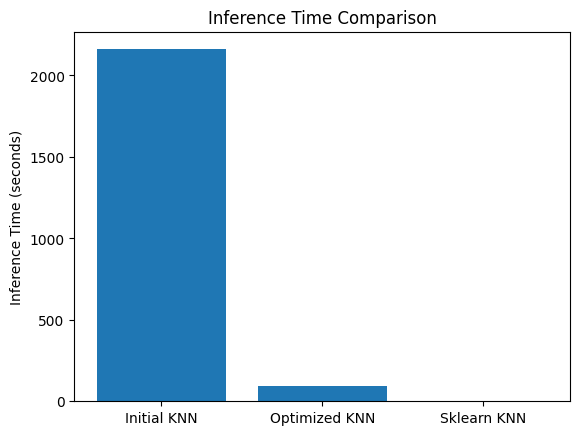

In [169]:
import matplotlib.pyplot as plt
# initial_times = []
# optimized_times = []
# sklearn_times = []

# initial_times.append(normal_time)
# optimized_times.append()
# sklearn_times.append(sklearn_time)

# Plot inference time comparison
model_names = ['Initial KNN', 'Optimized KNN', 'Sklearn KNN']
times = [normal_time, vectorized_time, sklearn_time]

plt.bar(model_names, times)
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison')
plt.show()


# for size in dataset_sizes:
#     subset = train_dataset[:size]
    
#     initial_knn.fit(subset)
#     initial_times.append(measure_inference_time(initial_knn, X_val, 'track_genre'))
    
#     optimized_knn.fit(subset)
#     optimized_times.append(measure_inference_time(optimized_knn, X_val, 'track_genre'))
    
#     sklearn_knn.fit(X_train[:size], y_train[:size])
#     start_time = time.time()
#     sklearn_knn.predict(X_val)
#     sklearn_times.append(time.time() - start_time)

# plt.plot(len(X_train), initial_times, label='Initial KNN')
# plt.plot(len(X_train), optimized_times, label='Optimized KNN')
# plt.plot(len(X_train), sklearn_times, label='Sklearn KNN')
# plt.xlabel('Training Dataset Size')
# plt.ylabel('Inference Time (seconds)')
# plt.title('Inference Time vs Training Dataset Size')
# plt.legend()
# plt.show()

In [172]:
# import matplotlib.pyplot as plt
# # initial_times = []
# # optimized_times = []
# # sklearn_times = []

# # initial_times.append(normal_time)
# # optimized_times.append()
# # sklearn_times.append(sklearn_time)

# # Plot inference time comparison
# model_names = ['Initial KNN', 'Optimized KNN', 'Sklearn KNN']
# times = [normal_time, vectorized_time, sklearn_time]

# plt.bar(model_names, times)
# plt.ylabel('Inference Time (seconds)')
# plt.title(f'Inference Time Comparison k={k}, metric={metric}')
# plt.show()
print(f"Initial Inference Time (s): {normal_time}")
print()
print(f"Optimised Inference Time (s): {vectorized_time}")
print()
print(f"Sklearn Inference Time (s): {sklearn_time}")
print()

Initial Inference Time (s): 2160.494178056717

Optimised Inference Time (s): 92.93741011619568

Sklearn Inference Time (s): 4.132826805114746



In [173]:
# from tqdm import tqdm

# # Predict the track genres on validation data with tqdm
# y_pred = []
# for val_row in tqdm(X_val, desc="Predicting", unit="sample"):
#     y_pred.append(knn.predict(val_row))

# # processing time 165 mins

In [174]:
# print(y_val)
# print(y_pred_2)
# # print(X_val)

# # # Get unique labels from y_train
# # unique_labels = sorted(set(y_train))  # Sorting ensures consistency in mapping

# # # Create the label mapping dictionary
# # label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# # # Inverse mapping (optional, for converting numeric predictions back to strings)
# # inverse_label_mapping = {idx: label for label, idx in label_mapping.items()}

# # # Display the mapping
# # print("Label Mapping (String to Numeric):", label_mapping)
# # print("Inverse Label Mapping (Numeric to String):", inverse_label_mapping)

# # # Example: Convert y_train to numeric labels using the mapping
# # y_train_numeric = [label_mapping[label] for label in y_train]

# # # Use inverse mapping to convert numeric predictions to string labels
# # # Assuming y_pred is a list of numeric predictions
# # y_pred_str = [inverse_label_mapping[pred] for pred in y_pred]

# # # Evaluate performance metrics using the validation data
# # performance_metrics = PerformanceMetrics(y_true=y_val, y_pred=y_pred)
# # metrics_result = performance_metrics.evaluate()

# # # Display the results
# # print("Performance Metrics on Validation Data:")
# # for metric_name, value in metrics_result.items():
# #     print(f"{metric_name}: {value:.4f}")


In [130]:
# dropping some features from the classification 
# dropping the numeric features : unnamed, duration
# dropping the categorical features: track_id, artists, album_name, track_name, 

In [178]:
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Initialize the list to store results
results = []

# Define the range of k values and possible distance metrics
max_k = 40
k_values_0 = range(1, 11)
k_values_1 = range(11, 21)
k_values_2 = range(21, 31)
k_values_3 = range(31, 41)

possible_distance_metrics = ["euclidean", "manhattan", "cosine"]
predictions={}

In [ ]:
# Iterate over all k values and distance metrics with a progress bar
for k in tqdm(k_values_0, desc="Processing k values"):
    for metric in possible_distance_metrics:
        # Measure the start time
        start_time = time.time()
        
        # Initialize the KNN model with the current k and distance metric
        knn = KNN(k=k, metric=metric, vectorized='Vectorization')
        
        # Combine features and labels for training data
        # train_dataset = [list(row) + [label] for row, label in zip(X_train, y_train)]
        
        # Fit the model
        knn.fit(train_data_X=X_train, train_data_Y=y_train)
        
        # Predict on validation data
        y_pred = knn.predict_batch(X_val)
        # y_pred_str = [inverse_label_mapping[pred] for pred in y_pred]
        # predictions[{k:metric}]=y_pred_str
        
        # Calculate validation accuracy
        performance_metrics = PerformanceMetrics(y_true=y_val, y_pred=y_pred)
        accuracy = performance_metrics.accuracy()
        
        # Measure the end time and calculate the processing time
        end_time = time.time()
        processing_time = end_time - start_time
        
        # Store the k, metric, accuracy, and processing time
        results.append({
            'k': k,
            'metric': metric,
            'accuracy': accuracy,
            'processing_time': processing_time
        })
        
        # Print a message indicating completion of this iteration
        print(f"Completed k={k}, metric={metric}. Processing time: {processing_time:.4f} seconds")


In [ ]:

# Iterate over all k values and distance metrics with a progress bar
for k in tqdm(k_values_1, desc="Processing k values"):
    for metric in possible_distance_metrics:
        # Measure the start time
        start_time = time.time()
        
        # Initialize the KNN model with the current k and distance metric
        knn = KNN(k=k, metric=metric, vectorized='Vectorization')
        
        # Combine features and labels for training data
        # train_dataset = [list(row) + [label] for row, label in zip(X_train, y_train)]
        
        # Fit the model
        knn.fit(train_data_X=X_train, train_data_Y=y_train)
        
        # Predict on validation data
        y_pred = knn.predict_batch(X_val)
        # y_pred_str = [inverse_label_mapping[pred] for pred in y_pred]
        # predictions[{k:metric}]=y_pred_str
        
        # Calculate validation accuracy
        performance_metrics = PerformanceMetrics(y_true=y_val, y_pred=y_pred)
        accuracy = performance_metrics.accuracy()
        
        # Measure the end time and calculate the processing time
        end_time = time.time()
        processing_time = end_time - start_time
        
        # Store the k, metric, accuracy, and processing time
        results.append({
            'k': k,
            'metric': metric,
            'accuracy': accuracy,
            'processing_time': processing_time
        })
        
        # Print a message indicating completion of this iteration
        print(f"Completed k={k}, metric={metric}. Processing time: {processing_time:.4f} seconds")


In [182]:
import pickle
# Save the list to a .txt file
with open('my_list.txt', 'wb') as file:  # Use 'wb' for binary mode
    pickle.dump(results, file)


In [183]:
# Iterate over all k values and distance metrics with a progress bar
for k in tqdm(k_values_2, desc="Processing k values"):
    for metric in possible_distance_metrics:
        # Measure the start time
        start_time = time.time()
        
        # Initialize the KNN model with the current k and distance metric
        knn = KNN(k=k, metric=metric, vectorized='Vectorization')
        
        # Combine features and labels for training data
        # train_dataset = [list(row) + [label] for row, label in zip(X_train, y_train)]
        
        # Fit the model
        knn.fit(train_data_X=X_train, train_data_Y=y_train)
        
        # Predict on validation data
        y_pred = knn.predict_batch(X_val)
        # y_pred_str = [inverse_label_mapping[pred] for pred in y_pred]
        # predictions[{k:metric}]=y_pred_str
        
        # Calculate validation accuracy
        performance_metrics = PerformanceMetrics(y_true=y_val, y_pred=y_pred)
        accuracy = performance_metrics.accuracy()
        
        # Measure the end time and calculate the processing time
        end_time = time.time()
        processing_time = end_time - start_time
        
        # Store the k, metric, accuracy, and processing time
        results.append({
            'k': k,
            'metric': metric,
            'accuracy': accuracy,
            'processing_time': processing_time
        })
        
        # Print a message indicating completion of this iteration
        print(f"Completed k={k}, metric={metric}. Processing time: {processing_time:.4f} seconds")


100%|██████████| 8974/8974 [01:29<00:00, 100.82it/s] ?it/s]


Completed k=21, metric=euclidean. Processing time: 89.0368 seconds


100%|██████████| 8974/8974 [01:32<00:00, 96.90it/s] 


Completed k=21, metric=manhattan. Processing time: 92.6300 seconds


Processing k values:  10%|█         | 1/10 [05:21<48:09, 321.00s/it]

Completed k=21, metric=cosine. Processing time: 139.3375 seconds


100%|██████████| 8974/8974 [01:26<00:00, 103.43it/s]


Completed k=22, metric=euclidean. Processing time: 86.7964 seconds


100%|██████████| 8974/8974 [01:35<00:00, 94.02it/s]


Completed k=22, metric=manhattan. Processing time: 95.4646 seconds


Processing k values:  20%|██        | 2/10 [10:44<43:00, 322.56s/it]

Completed k=22, metric=cosine. Processing time: 141.3879 seconds


100%|██████████| 8974/8974 [01:27<00:00, 102.77it/s]


Completed k=23, metric=euclidean. Processing time: 87.3596 seconds


100%|██████████| 8974/8974 [01:30<00:00, 99.03it/s]


Completed k=23, metric=manhattan. Processing time: 90.6404 seconds


Processing k values:  30%|███       | 3/10 [15:20<35:08, 301.25s/it]

Completed k=23, metric=cosine. Processing time: 97.8901 seconds


100%|██████████| 8974/8974 [01:25<00:00, 105.42it/s]


Completed k=24, metric=euclidean. Processing time: 85.1460 seconds


100%|██████████| 8974/8974 [01:34<00:00, 94.99it/s]


Completed k=24, metric=manhattan. Processing time: 94.4921 seconds


Processing k values:  40%|████      | 4/10 [20:10<29:41, 296.96s/it]

Completed k=24, metric=cosine. Processing time: 110.7501 seconds


100%|██████████| 8974/8974 [01:29<00:00, 100.74it/s]


Completed k=25, metric=euclidean. Processing time: 89.1106 seconds


100%|██████████| 8974/8974 [01:34<00:00, 94.65it/s]


Completed k=25, metric=manhattan. Processing time: 94.8356 seconds


Processing k values:  50%|█████     | 5/10 [25:00<24:30, 294.18s/it]

Completed k=25, metric=cosine. Processing time: 105.2895 seconds


100%|██████████| 8974/8974 [01:25<00:00, 105.43it/s]


Completed k=26, metric=euclidean. Processing time: 85.1398 seconds


100%|██████████| 8974/8974 [02:00<00:00, 74.34it/s] 


Completed k=26, metric=manhattan. Processing time: 120.7302 seconds


Processing k values:  60%|██████    | 6/10 [29:47<19:27, 291.90s/it]

Completed k=26, metric=cosine. Processing time: 81.5957 seconds


100%|██████████| 8974/8974 [00:52<00:00, 171.49it/s]


Completed k=27, metric=euclidean. Processing time: 52.3455 seconds


100%|██████████| 8974/8974 [00:55<00:00, 160.94it/s]


Completed k=27, metric=manhattan. Processing time: 55.7693 seconds


Processing k values:  70%|███████   | 7/10 [32:46<12:44, 254.99s/it]

Completed k=27, metric=cosine. Processing time: 70.8896 seconds


100%|██████████| 8974/8974 [00:52<00:00, 170.65it/s]


Completed k=28, metric=euclidean. Processing time: 52.5999 seconds


100%|██████████| 8974/8974 [00:55<00:00, 161.83it/s]


Completed k=28, metric=manhattan. Processing time: 55.4647 seconds


Processing k values:  80%|████████  | 8/10 [35:50<07:44, 232.23s/it]

Completed k=28, metric=cosine. Processing time: 75.4467 seconds


100%|██████████| 8974/8974 [00:52<00:00, 171.20it/s]


Completed k=29, metric=euclidean. Processing time: 52.4371 seconds


100%|██████████| 8974/8974 [01:00<00:00, 148.61it/s]


Completed k=29, metric=manhattan. Processing time: 60.4053 seconds


Processing k values:  90%|█████████ | 9/10 [39:14<03:43, 223.57s/it]

Completed k=29, metric=cosine. Processing time: 91.6616 seconds


100%|██████████| 8974/8974 [00:53<00:00, 166.77it/s]


Completed k=30, metric=euclidean. Processing time: 53.8254 seconds


100%|██████████| 8974/8974 [00:59<00:00, 150.35it/s]


Completed k=30, metric=manhattan. Processing time: 59.7005 seconds


Processing k values: 100%|██████████| 10/10 [42:37<00:00, 255.72s/it]

Completed k=30, metric=cosine. Processing time: 89.0302 seconds


In [ ]:
# # Iterate over all k values and distance metrics with a progress bar
# for k in tqdm(k_values_3, desc="Processing k values"):
#     for metric in possible_distance_metrics:
#         # Measure the start time
#         start_time = time.time()
        
#         # Initialize the KNN model with the current k and distance metric
#         knn = KNN(k=k, metric=metric, vectorized='Vectorization')
        
#         # Combine features and labels for training data
#         # train_dataset = [list(row) + [label] for row, label in zip(X_train, y_train)]
        
#         # Fit the model
#         knn.fit(train_data_X=X_train, train_data_Y=y_train)
        
#         # Predict on validation data
#         y_pred = knn.predict_batch(X_val)
#         # y_pred_str = [inverse_label_mapping[pred] for pred in y_pred]
#         # predictions[{k:metric}]=y_pred_str
        
#         # Calculate validation accuracy
#         performance_metrics = PerformanceMetrics(y_true=y_val, y_pred=y_pred)
#         accuracy = performance_metrics.accuracy()
        
#         # Measure the end time and calculate the processing time
#         end_time = time.time()
#         processing_time = end_time - start_time
        
#         # Store the k, metric, accuracy, and processing time
#         results.append({
#             'k': k,
#             'metric': metric,
#             'accuracy': accuracy,
#             'processing_time': processing_time
#         })
        
#         # Print a message indicating completion of this iteration
#         print(f"Completed k={k}, metric={metric}. Processing time: {processing_time:.4f} seconds")


In [185]:
list_3 = list()
import pickle

# Load the list from the .txt file
with open('my_list_3.txt', 'rb') as file:  # Use 'rb' for reading in binary mode
    list_3 = pickle.load(file)

# # Load the list from the .txt file
# with open('my_list_2.txt', 'rb') as file:  # Use 'rb' for reading in binary mode
#     list_3 = pickle.load(file)


print(list_3)
results.extend(list_3)

[{'k': 31, 'metric': 'euclidean', 'accuracy': 0.18219300200579452, 'processing_time': 57.87285494804382}, {'k': 31, 'metric': 'manhattan', 'accuracy': 0.19367060396701583, 'processing_time': 60.63056683540344}, {'k': 31, 'metric': 'cosine', 'accuracy': 0.17873857811455315, 'processing_time': 86.174880027771}, {'k': 32, 'metric': 'euclidean', 'accuracy': 0.17963004234455093, 'processing_time': 56.02797794342041}, {'k': 32, 'metric': 'manhattan', 'accuracy': 0.1935591709382661, 'processing_time': 60.97793793678284}, {'k': 32, 'metric': 'cosine', 'accuracy': 0.1774013817695565, 'processing_time': 90.42140913009644}, {'k': 33, 'metric': 'euclidean', 'accuracy': 0.1810786717182973, 'processing_time': 55.74736213684082}, {'k': 33, 'metric': 'manhattan', 'accuracy': 0.19400490305326498, 'processing_time': 61.25095772743225}, {'k': 33, 'metric': 'cosine', 'accuracy': 0.17461555605081347, 'processing_time': 90.639315366745}, {'k': 34, 'metric': 'euclidean', 'accuracy': 0.17974147537330065, 'pro


Top 10 {k, distance metric} pairs based on validation accuracy:
Rank 1: k=12, metric=manhattan, accuracy=0.2007, processing time: 91.5786 seconds
Rank 2: k=11, metric=manhattan, accuracy=0.2005, processing time: 89.1226 seconds
Rank 3: k=16, metric=manhattan, accuracy=0.2001, processing time: 91.0607 seconds
Rank 4: k=17, metric=manhattan, accuracy=0.1995, processing time: 91.7099 seconds
Rank 5: k=13, metric=manhattan, accuracy=0.1994, processing time: 171.3577 seconds
Rank 6: k=18, metric=manhattan, accuracy=0.1988, processing time: 91.1969 seconds
Rank 7: k=15, metric=manhattan, accuracy=0.1981, processing time: 91.7165 seconds
Rank 8: k=19, metric=manhattan, accuracy=0.1976, processing time: 91.7499 seconds
Rank 9: k=23, metric=manhattan, accuracy=0.1972, processing time: 90.6404 seconds
Rank 10: k=14, metric=manhattan, accuracy=0.1970, processing time: 91.2799 seconds


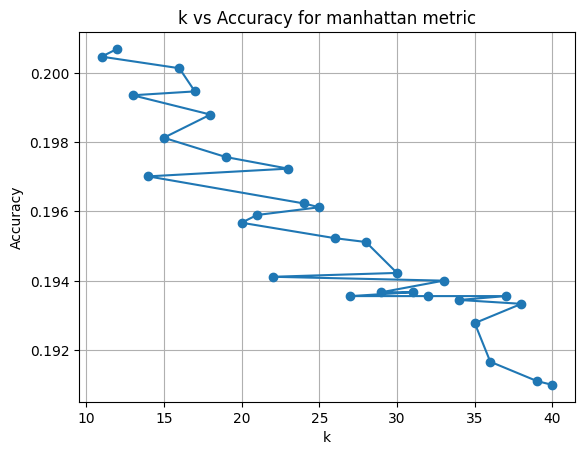

In [186]:

# Sort the results by accuracy in descending order
results_sorted = sorted(results, key=lambda x: x['accuracy'], reverse=True)

# Print an ordered rank list of the top 10 such pairs
print("\nTop 10 {k, distance metric} pairs based on validation accuracy:")
for i, result in enumerate(results_sorted[:10]):
    print(f"Rank {i + 1}: k={result['k']}, metric={result['metric']}, accuracy={result['accuracy']:.4f}, processing time: {result['processing_time']:.4f} seconds")

# Plot k vs accuracy for a given distance metric (e.g., 'euclidean')
chosen_metric = 'manhattan'
k_vs_accuracy = [(result['k'], result['accuracy']) for result in results_sorted if result['metric'] == chosen_metric]

k_values_plot = [item[0] for item in k_vs_accuracy]
accuracy_values_plot = [item[1] for item in k_vs_accuracy]

plt.plot(k_values_plot, accuracy_values_plot, marker='o')
plt.title(f'k vs Accuracy for {chosen_metric} metric')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [ ]:
# Different training sizes
train_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000]
initial_times = []
best_times = []
optimized_times = []
sklearn_times = []

# Function to measure inference time
def measure_inference_time(knn, X_val, y_val):
    start_time = time.time()
    y_pred = knn.predict(X_val)
    end_time = time.time()
    inference_time = end_time - start_time
    pf = PerformanceMetrics(y_val, y_pred)
    accuracy = pf.accuracy()
    return inference_time, accuracy

for size in train_sizes:
    # Select the first 'size' points from the training set
    X_train_subset = X_train[:size]
    y_train_subset = y_train[:size]
    
    # # Initial KNN model
    # initial_knn = KNN(k=3, metric='euclidean')
    # initial_knn.fit(X_train_subset, y_train_subset)
    # inference_time, _ = measure_inference_time(initial_knn, X_val[:size], y_val[:size])
    # initial_times.append(inference_time)
    
    # # Best KNN model
    # best_knn = KNN(k=, metric='manhattan')
    # best_knn.fit(X_train_subset, y_train_subset)
    # inference_time, _ = measure_inference_time(best_knn, X_val[:size], y_val[:size])
    # best_times.append(inference_time)
    
    # Optimized KNN model
    optimized_knn = KNN(k=7, metric='cosine', vectorized='Vectorization')
    optimized_knn.fit(X_train_subset, y_train_subset)
    inference_time, _ = measure_inference_time(optimized_knn, X_val[:size], y_val[:size])
    optimized_times.append(inference_time)
    
    # sklearn KNN model
    sklearn_knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
    sklearn_knn.fit(X_train_subset, y_train_subset)
    inference_time, _ = measure_inference_time(sklearn_knn, X_val[:size], y_val[:size])
    sklearn_times.append(inference_time)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, initial_times, label='Initial KNN Model')
plt.plot(train_sizes, best_times, label='Best KNN Model')
plt.plot(train_sizes, optimized_times, label='Optimized KNN Model')
plt.plot(train_sizes, sklearn_times, label='Sklearn KNN Model')
plt.xlabel('Training Dataset Size')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time vs Training Dataset Size')
plt.legend()
plt.grid(True)
plt.show()

In [109]:
# import matplotlib.pyplot as plt
# import time

# # class OptimizedKNN(KNN):
# #     def calculate_distance(self, row1, row2):
# #         row1 = np.array(row1)
# #         row2 = np.array(row2)
# #         if self.metric == 'euclidean':
# #             return np.sqrt(np.sum((row1 - row2) ** 2, axis=1))
# #         elif self.metric == 'manhattan':
# #             return np.sum(np.abs(row1 - row2), axis=1)
# #         elif self.metric == 'cosine':
# #             dot_product = np.dot(row1, row2)
# #             return 1 - dot_product / (np.linalg.norm(row1, axis=1) * np.linalg.norm(row2))

# #     def predict(self, test_row):
# #         distances = self.calculate_distance(np.array(self.train_dataset)[:, :-1], test_row)
# #         sorted_indices = np.argsort(distances)
# #         k_nearest = [self.train_dataset[i][-1] for i in sorted_indices[:self.k]]
# #         return max(set(k_nearest), key=k_nearest.count)

# # # Data Loading (paths to be updated accordingly)
# # train_data = pd.read_csv('/mnt/data/train_data.csv')
# # val_data = pd.read_csv('/mnt/data/val_data.csv')

# X_train = train_data.iloc[:, 1:-1].values
# y_train = train_data['track_genre'].values
# X_val = val_data.iloc[:, 1:-1].values
# y_val = val_data['track_genre'].values

# # train_dataset = [list(row) + [label] for row, label in zip(X_train, y_train)]

# # Initial KNN Model
# initial_knn = KNN(k=19, metric='euclidean', vectorized=None)
# initial_knn.fit(X_train, y_train)
# start_time = time.time()
# initial_knn.predict_batch(X_val)
# # end_time = time.time()
# initial_time = time.time() - start_time

# # Best KNN Model time already stored 

# # Optimized KNN Model
# optim_knn = KNN(k=19, metric='euclidean', vectorized='Vectorization')
# optim_knn.fit(X_train, y_train)
# start_time = time.time()
# optim_knn.predict_batch(X_val)
# # end_time = 
# optimized_time = time.time() - start_time

# # Sklearn KNN Model
# from sklearn.neighbors import KNeighborsClassifier
# sklearn_knn = KNeighborsClassifier(n_neighbors=19, metric='euclidean')
# sklearn_knn.fit(X_train, y_train)
# start_time = time.time()
# sklearn_knn.predict(X_val)
# sklearn_time = time.time() - start_time

# # Plot inference time comparison
# model_names = ['Initial KNN', 'Optimized KNN', 'Sklearn KNN']
# times = [initial_time, optimized_time, sklearn_time]

# plt.bar(model_names, times)
# plt.ylabel('Inference Time (seconds)')
# plt.title('Inference Time Comparison')
# plt.show()

# # Plot inference time vs train dataset size
# dataset_sizes = [len(X_train) // 10 * i for i in range(1, 11)]
# initial_times = []
# optimized_times = []
# sklearn_times = []

# # for size in dataset_sizes:
# #     subset = train_dataset[:size]
    
# #     initial_knn.fit(subset)
# #     initial_times.append(measure_inference_time(initial_knn, X_val, 'track_genre'))
    
# #     optimized_knn.fit(subset)
# #     optimized_times.append(measure_inference_time(optimized_knn, X_val, 'track_genre'))
    
# #     sklearn_knn.fit(X_train[:size], y_train[:size])
# #     start_time = time.time()
# #     sklearn_knn.predict(X_val)
# #     sklearn_times.append(time.time() - start_time)

# plt.plot(dataset_sizes, initial_times, label='Initial KNN')
# plt.plot(dataset_sizes, optimized_times, label='Optimized KNN')
# plt.plot(dataset_sizes, sklearn_times, label='Sklearn KNN')
# plt.xlabel('Training Dataset Size')
# plt.ylabel('Inference Time (seconds)')
# plt.title('Inference Time vs Training Dataset Size')
# plt.legend()
# plt.show()

Predicting:  10%|█         | 935/8974 [00:12<01:48, 73.81sample/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_16843/2422723807.py", line 37, in <module>
    initial_knn.predict_batch(X_val)
  File "/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_16843/207825060.py", line 117, in predict_batch
    predictions.append(self.predict(test_row))
                       ^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_16843/207825060.py", line 101, in predict
    distances = self.dist_func(self.X_train, test_row)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/js/n7mnpc4915x2hstjlmdjm3_m0000gn/T/ipykernel_16843/4024220079.py", line -1, in euclidean_distance
KeyboardInterrupt

During handling of the above exception, another exc

In [187]:
# Load the training data from CSV
train_data = pd.read_csv(train_data_path)
val_data = pd.read_csv(val_data_path)

train_data = train_data.drop(columns=features_to_drop)
val_data = val_data.drop(columns=features_to_drop)

# Remove the first column (serial number) and extract features and labels
X_train = train_data.iloc[:, 1:-1].values  # Features from training data
y_train = train_data['track_genre'].values  # Labels from training data

X_val = val_data.iloc[:, 1:-1].values  # Features from validation data
y_val = val_data['track_genre'].values  # Labels from validation data

In [188]:
# Create KNN object
k = 12  # Set the value of k
metric = 'manhattan'  # Choose the distance metric
# knn = KNN(k, metric)

start = time.time()
y_pred = evaluate_knn(k,metric, 'Vectorization')
vectorized_time = time.time() - start

100%|██████████| 8974/8974 [00:53<00:00, 166.83it/s]

{'accuracy': 0.20069088477824829, 'precision_macro': 0.19285527089614388, 'recall_macro': 0.1921779948374726, 'f1_score_macro': 0.19251603720027696, 'precision_micro': 0.20069088477824829, 'recall_micro': 0.20069088477824829, 'f1_score_micro': 0.20069088477824829}
